In [72]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

In [73]:
df=pd.read_parquet('C:/Users/visha/Downloads/data.parquet')
df['Time'] = df.index.time
start_time = '09:15:00'  # Example start time
end_time = '15:30:00'    # Example end time
start_time = pd.Timestamp(start_time).time()
end_time = pd.Timestamp(end_time).time()

# Filter data between start and end times for every day
filtered_data = df[(df['Time'] >= start_time) & (df['Time'] <= end_time)]

# Drop the 'Time' column as it's no longer needed
filtered_data.drop(columns=['Time'], inplace=True)

In [74]:
filtered_data.index = pd.to_datetime(filtered_data.index)
filtered_data1 = filtered_data[filtered_data.index.dayofweek < 5]
df = filtered_data1[:11280]
df

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27
...,...,...,...
2021-02-11 15:26:00,0.252609,0.179759,14
2021-02-11 15:27:00,0.251959,0.179522,14
2021-02-11 15:28:00,0.252144,0.179781,14


In [75]:
df = df.dropna()
S1 = df['nifty']
S2 = df['banknifty']

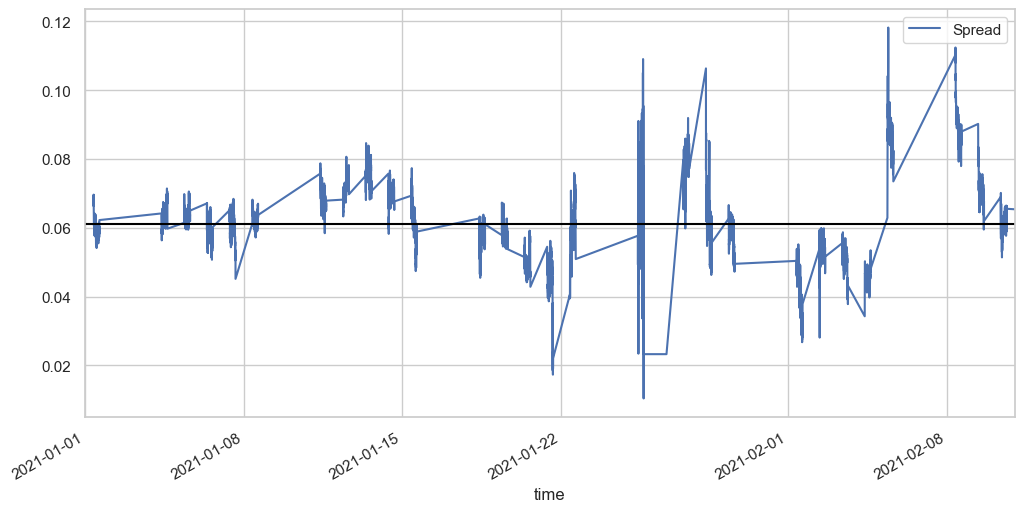

In [76]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['nifty']
b = results.params['nifty']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2021-01-01', '2021-02-11')
plt.legend(['Spread']);

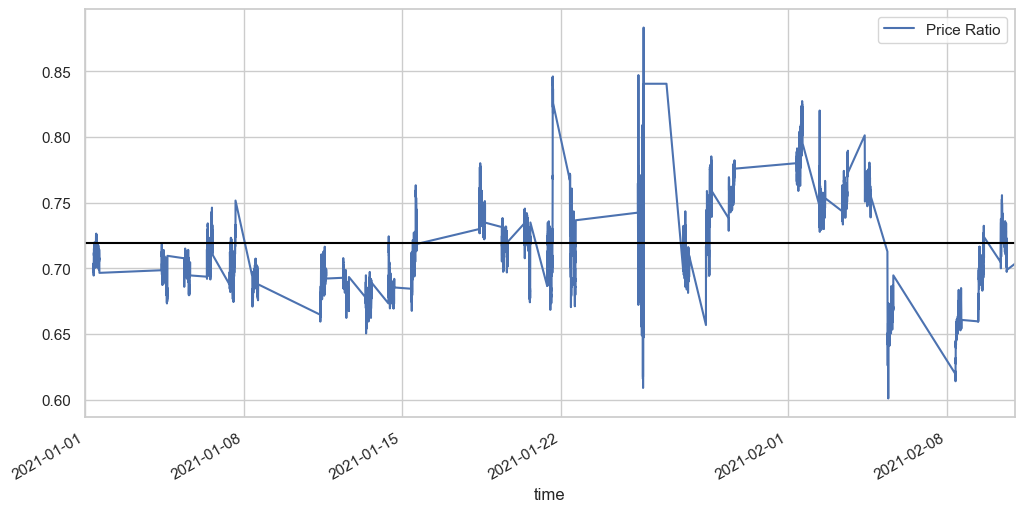

In [77]:
ratio = S1/S2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2021-01-01', '2021-02-11')
plt.legend(['Price Ratio']);

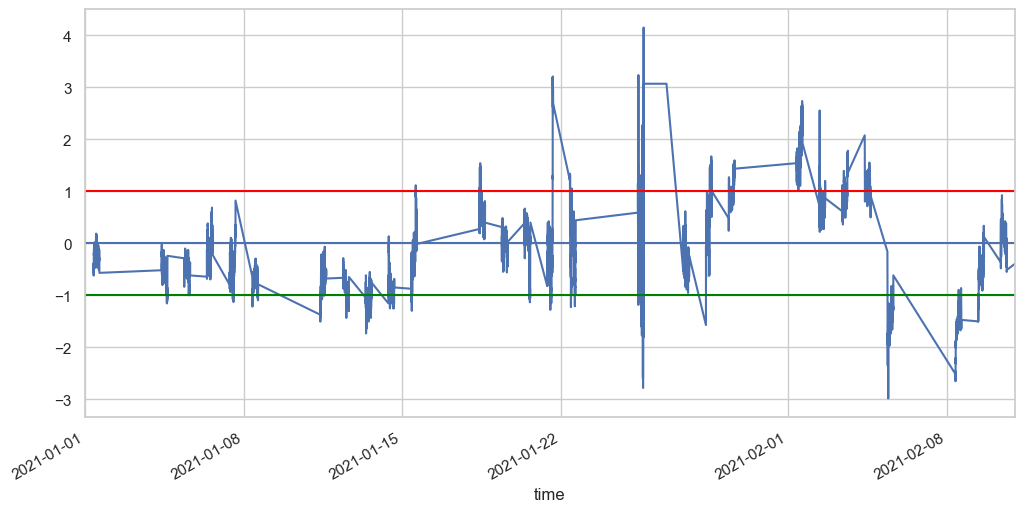

In [78]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2021-01-01', '2021-02-11')
plt.show()

In [79]:
ratios = df['nifty'] / df['banknifty'] 
print(len(ratios) * .70 ) 

7860.299999999999


In [80]:
train = ratios[:7860]
test = ratios[7860:]

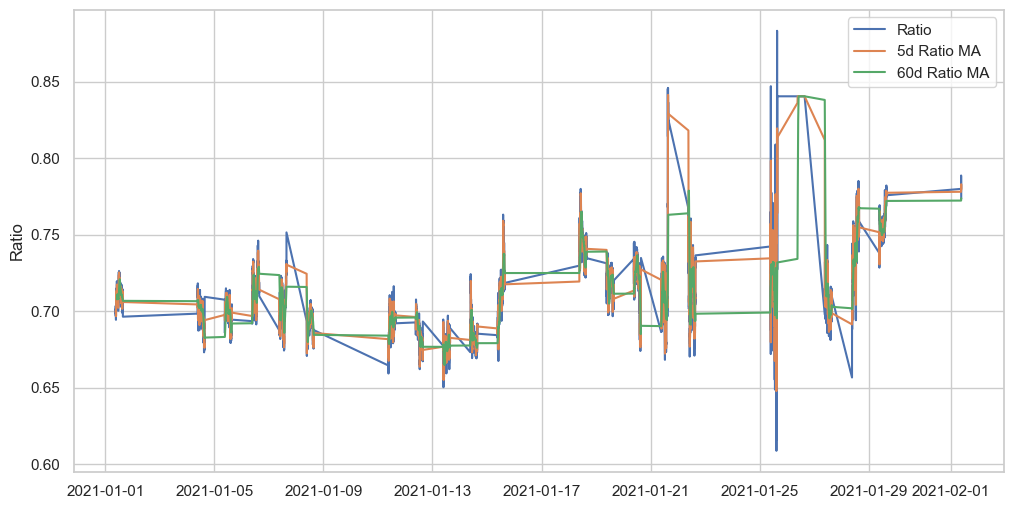

In [81]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

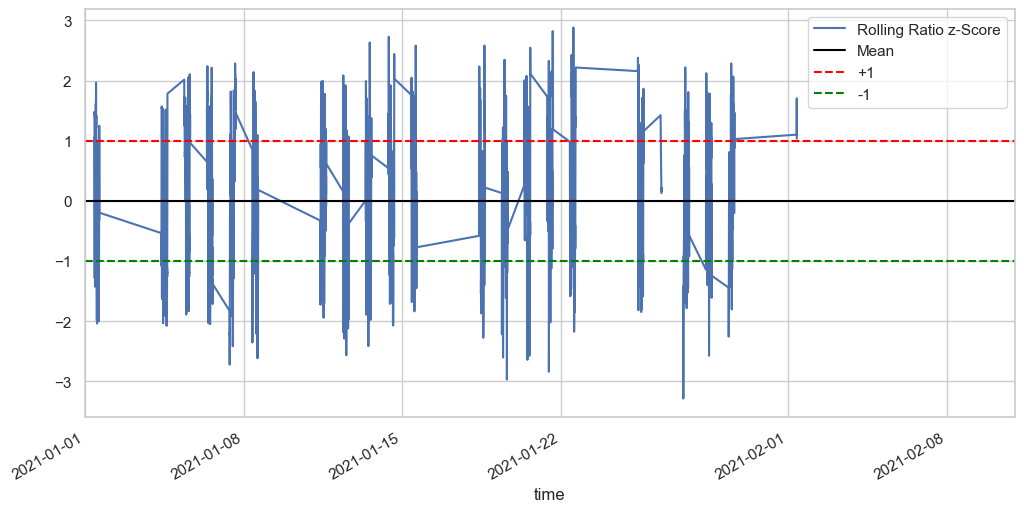

In [82]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.xlim('2021-01-01', '2021-02-11')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

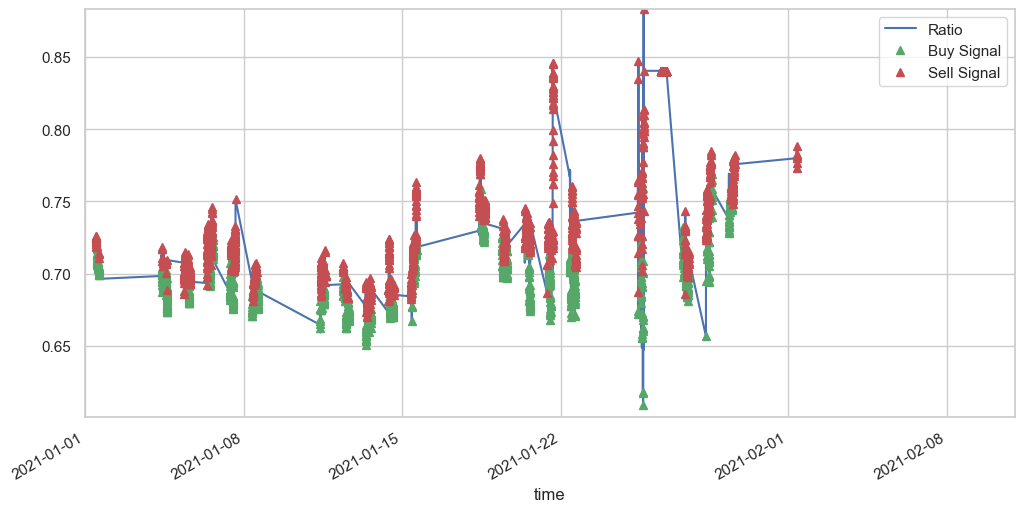

In [83]:
plt.figure(figsize=(12,6))

train[160:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.xlim('2021-01-01', '2021-02-11')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

In [84]:
df

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27
...,...,...,...
2021-02-11 15:26:00,0.252609,0.179759,14
2021-02-11 15:27:00,0.251959,0.179522,14
2021-02-11 15:28:00,0.252144,0.179781,14


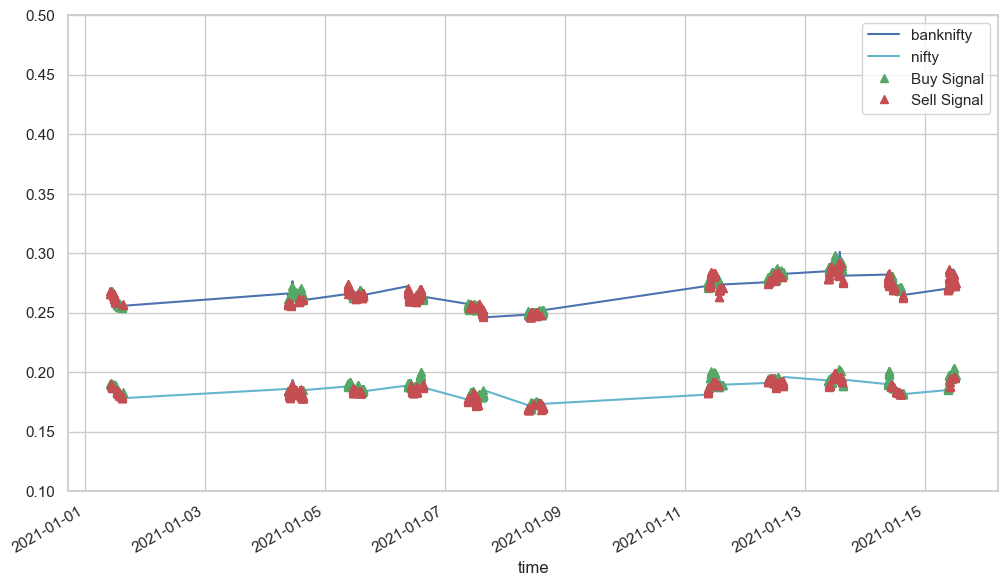

In [85]:
plt.figure(figsize=(12,7))
S1 = df['banknifty'].iloc[:3930]
S2 = df['nifty'].iloc[:3930]

S1[60:].plot(color='b')
S2[60:].plot(color='c')

buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(0.1, 0.5)
# plt.xlim('2021-01-01', '2021-02-11')
plt.legend(['banknifty', 'nifty', 'Buy Signal', 'Sell Signal'])
plt.show()

In [103]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    # temp = 0
    # df['return'] = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if i>0:
            if zscore[i] < -1:
                money += S1[i] - S2[i] * ratios[i]
                # money = S1[i] - S2[i] * ratios[i]
                # print("Money if z less than -1",money)
                countS1 -= 1
                countS2 += ratios[i]
                df['return'].iloc[i] = money
                #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
            # Buy long if the z-score is < -1
            elif zscore[i] > 1:
                money -= S1[i] - S2[i] * ratios[i]
                # money = S1[i] - S2[i] * ratios[i]
                # print("Money if z gt than 1",money)
                countS1 += 1
                countS2 -= ratios[i]
                # df['return'].iloc[i] = money
                #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
            # Clear positions if the z-score between -.5 and .5
            elif abs(zscore[i]) < 0.75:
                money += S1[i] * countS1 + S2[i] * countS2
                # money = S1[i] * countS1 + S2[i] * countS2
                # print("Money if z lt 0.75",money)
                countS1 = 0
                countS2 = 0
                #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
                # df['return'].iloc[i] = money
            # temp = money
    
    return money

In [104]:
trade(df['nifty'].iloc[7860:], df['banknifty'].iloc[7860:], 240, 5)

6.390674694422711

In [100]:
df['cummulative_returns']=df['return'].cumsum()
sharpe_ratio = df['return'].mean()/df['return'].std()
cumulative_return_cummax= df['cummulative_returns'].cummax()
drawdown = df['cummulative_returns'] - cumulative_return_cummax
print("Sharpe ratio: ", sharpe_ratio)
print("Maximum Drawdown: ", drawdown.min())
cumulative_return = df['cummulative_returns'].iloc[-1]
print("Cummulative Returns", cumulative_return)

Sharpe ratio:  0.03519255856516604
Maximum Drawdown:  -0.6749462824254593
Cummulative Returns 6.390674694422711


In [105]:
length_scores = [trade(df['nifty'].iloc[:7860], 
                df['banknifty'].iloc[:7860], l, 5) 
                for l in range(255)]
best_length = np.argmax(length_scores)
print ('Best window length:', best_length)

In [ ]:
length_scores2 = [trade(df['nifty'].iloc[7860:], 
                  df['banknifty'].iloc[7860:],l,5) 
                  for l in range(255)]
print (best_length, 'day window:', length_scores2[best_length])
# Find the best window length based on this dataset, 
# and the returns using this window length
best_length2 = np.argmax(length_scores2)
print (best_length2, 'day window:', length_scores2[best_length2])

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(length_scores)
plt.plot(length_scores2)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['Training', 'Test'])
plt.show()